# Install & Import Libraries (Install Dependencies)


In [3]:
!pip install yfinance joblib ta --quiet
!pip install tensorflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import yfinance as yf
import joblib
import os
import ta

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


# Create Directory & Download Stock Data

In [5]:
os.makedirs("data", exist_ok=True)

# Download AAPL stock data
df = yf.download("AAPL", start="2015-01-01", end="2025-01-01")
df.to_csv("data/raw_stock.csv")

[*********************100%***********************]  1 of 1 completed


# Add Technical Indicators

In [7]:
# Load CSV properly and convert necessary columns to numeric
df = pd.read_csv("data/raw_stock.csv")

# Ensure 'Close' column is numeric
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

# Drop any rows with NaNs (including those caused by coercion)
df.dropna(subset=['Close'], inplace=True)

# Calculate technical indicators (safe now)
df['SMA_20'] = ta.trend.sma_indicator(df['Close'], window=20)
df['EMA_20'] = ta.trend.ema_indicator(df['Close'], window=20)
df['RSI'] = ta.momentum.rsi(df['Close'], window=14)
df['MACD'] = ta.trend.macd_diff(df['Close'])
bb = ta.volatility.BollingerBands(df['Close'], window=20)
df['BB_High'] = bb.bollinger_hband()
df['BB_Low'] = bb.bollinger_lband()

# Drop NaNs from indicator calculations
df.dropna(inplace=True)

# Save cleaned and enriched dataset
df.to_csv("data/processed_stock.csv", index=False)
df.head()


,Price,Close,High,Low,Open,Volume,SMA_20,EMA_20,RSI,MACD,BB_High,BB_Low
35,2015-02-20,28.920938,28.92093849182129,28.59711399333912,28.724409016235786,195793600,26.942900,27.182864,78.737110,0.146918,29.578009,24.307791
36,2015-02-23,29.702587,29.702587127685547,28.956673351502488,29.03707146800615,283896400,27.171411,27.422838,82.379092,0.172409,29.928674,24.414148
37,2015-02-24,29.517225,29.836585687088274,29.293897538526853,29.6891885694335,276912400,27.389319,27.622303,78.926602,0.158819,30.164787,24.613850
38,2015-02-25,28.762377,29.389930567701946,28.61944717469499,29.38099555020321,298846800,27.613529,27.730882,66.672388,0.084741,30.051427,25.175632
39,2015-02-26,29.126396,29.226892955598142,28.275518247199624,28.762370963301535,365150000,27.787315,27.863788,69.159169,0.047844,30.134598,25.440033


# Scale & Create Sequences

In [8]:
# Select relevant features
features = ['Close', 'SMA_20', 'EMA_20', 'RSI', 'MACD', 'BB_High', 'BB_Low']
data = df[features].values

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
joblib.dump(scaler, "data/scaler_multi.save")

# Sequence builder
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step])
        y.append(data[i+time_step][0])  # Target is 'Close'
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)


# Train-Test Split & Reshape



In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Input format for LSTM: [samples, time steps, features]
print("X shape:", X_train.shape)


X shape: (1938, 60, 7)


# Build and Train Model



In [10]:
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("data/best_model.h5", monitor='val_loss', save_best_only=True)
]

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0063

49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 203ms/step - loss: 0.0062 - val_loss: 0.0013
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 9.3078e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 9.2947e-04 - val_loss: 9.4599e-04
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - loss: 5.6372e-04 - val_loss: 0.0014
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 5.6176e-04 - val_loss: 0.0010
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 5.3395e-04 - val_loss: 0.0019
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 3.9688e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 3.9651e-04 - val_loss: 8.5142e-04
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - loss: 3.8554e-04 - val_loss: 0.0023
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 3.8261e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - loss: 3.8269e-04 - val_loss: 6.7773e-04
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 4.1549e-04 - val_loss: 8.8137e-04
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 3.1236e-04 - val_loss: 0.0023
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 2.8934e-04 - val_loss: 6.9692e-04
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - loss: 3.3795e-04 - val_loss: 0.0017
Epoch 13/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 2.5929e-04 - val_loss: 0.0012
Epoch 14/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - loss: 2.4244e-04 - val_loss: 8.6844e-04
Epoch 15/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - loss: 3.0536e-04 - val_loss: 0.0018
Epoch 16/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - loss: 2.8275e-04 - val_loss: 0.0023
Epoch 17/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - loss: 2.8775e-04 - val_loss: 9.0217e-04
Epoch 18/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - loss: 2.2415e-04 -

# Predict and Inverse Scale


In [11]:
# Predict
predictions = model.predict(X_test)

# Rescale
scaler = joblib.load("data/scaler_multi.save")
predicted_prices = scaler.inverse_transform(
    np.hstack((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1]-1))))
)[:, 0]

actual_prices = scaler.inverse_transform(
    np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1]-1))))
)[:, 0]


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


# Plot the Results

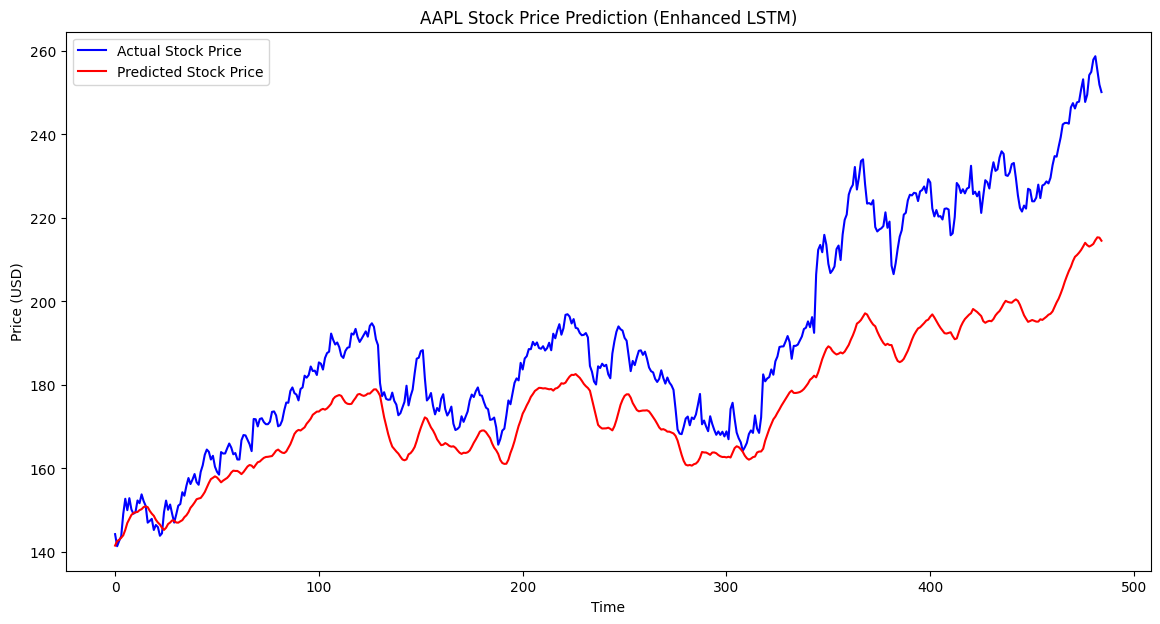

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(actual_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Stock Price')
plt.title('AAPL Stock Price Prediction (Enhanced LSTM)')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


# Save the Model in .h5 or .keras Format

In [14]:
ModelCheckpoint("data/best_model.h5", monitor='val_loss', save_best_only=True)


In [15]:
model.save("data/final_model.keras")  # or use .h5 extension

# Download the Model in Google Colab

In [16]:
from google.colab import files
files.download("data/final_model.keras")  # Or "data/best_model.h5"


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Optional – Save the Scaler Too


In [17]:

import joblib
joblib.dump(scaler, "data/scaler.pkl")
files.download("data/scaler.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load the Model Later

In [ ]:
"""
from tensorflow.keras.models import load_model
import joblib

model = load_model("data/final_model.keras")  # Or best_model.h5
scaler = joblib.load("data/scaler.pkl")

"""

# Another One!! Another One!!

## Setup & Download Data


In [19]:
!pip install yfinance ta keras-tuner scikit-learn -q
import os
os.makedirs("data", exist_ok=True)

import yfinance as yf
import pandas as pd

df = yf.download("AAPL", start="2015-01-01", end="2025-01-01")
df.to_csv("data/raw_stock1.csv")


[*********************100%***********************]  1 of 1 completed


## Add Technical Indicators

In [20]:
import ta

df = pd.read_csv("data/raw_stock1.csv")
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df.dropna(subset=['Close'], inplace=True)

df['SMA_20'] = ta.trend.sma_indicator(df['Close'], window=20)
df['EMA_20'] = ta.trend.ema_indicator(df['Close'], window=20)
df['RSI'] = ta.momentum.rsi(df['Close'], window=14)
df['MACD'] = ta.trend.macd_diff(df['Close'])
bb = ta.volatility.BollingerBands(df['Close'], window=20)
df['BB_High'] = bb.bollinger_hband()
df['BB_Low'] = bb.bollinger_lband()

df.dropna(inplace=True)
df.to_csv("data/processed_stock.csv", index=False)


## Prepare Sequences

In [21]:
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/processed_stock.csv")
features = ['Close', 'SMA_20', 'EMA_20', 'RSI', 'MACD', 'BB_High', 'BB_Low']
data = df[features].values

scaler = RobustScaler()
scaled_data = scaler.fit_transform(data)

def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i - time_step:i])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


## Define Model & Save Version 1

In [22]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define first model (V1)
model_v1 = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(1)
])

model_v1.compile(optimizer='adam', loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
mc = ModelCheckpoint("data/model_v1.keras", save_best_only=True)

model_v1.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=32, callbacks=[es, mc])


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 0.0293 - val_loss: 0.0046
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0035 - val_loss: 0.0072
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0021 - val_loss: 0.0107
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0016 - val_loss: 0.0045
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0016 - val_loss: 0.0066
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0

## Train Enhanced Model (V2)

In [23]:
# Define second model (V2)
model_v2 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.1),
    Bidirectional(LSTM(64)),
    Dropout(0.1),
    Dense(1)
])

model_v2.compile(optimizer='adam', loss='mean_squared_error')

es2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
mc2 = ModelCheckpoint("data/model_v2.keras", save_best_only=True)

model_v2.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=32, callbacks=[es2, mc2])


Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - loss: 0.0230 - val_loss: 0.0020
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - loss: 8.8576e-04 - val_loss: 0.0020
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - loss: 8.0289e-04 - val_loss: 0.0021
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - loss: 0.0010 - val_loss: 0.0021


## Compare Accuracy of Both Models

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def evaluate_model(model_path, name):
    model = load_model(model_path)
    predictions = model.predict(X_test)
    predictions_rescaled = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], X.shape[2]-1)))))[:,0]
    y_true_rescaled = scaler.inverse_transform(np.hstack((y_test.reshape(-1,1), np.zeros((y_test.shape[0], X.shape[2]-1)))))[:,0]

    mse = mean_squared_error(y_true_rescaled, predictions_rescaled)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_rescaled, predictions_rescaled)
    r2 = r2_score(y_true_rescaled, predictions_rescaled)

    print(f"📊 {name} Evaluation")
    print(f"  MSE : {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE : {mae:.4f}")
    print(f"  R²  : {r2:.4f}")
    print("-" * 30)

    return predictions_rescaled, y_true_rescaled

pred_v1, actual = evaluate_model("data/model_v1.keras", "Model V1")
pred_v2, _ = evaluate_model("data/model_v2.keras", "Model V2")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
📊 Model V1 Evaluation
  MSE : 141.6678
  RMSE: 11.9024
  MAE : 9.4300
  R²  : 0.7995
------------------------------
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step
📊 Model V2 Evaluation
  MSE : 106.6979
  RMSE: 10.3295
  MAE : 7.9218
  R²  : 0.8490
------------------------------


# Plot Comparison

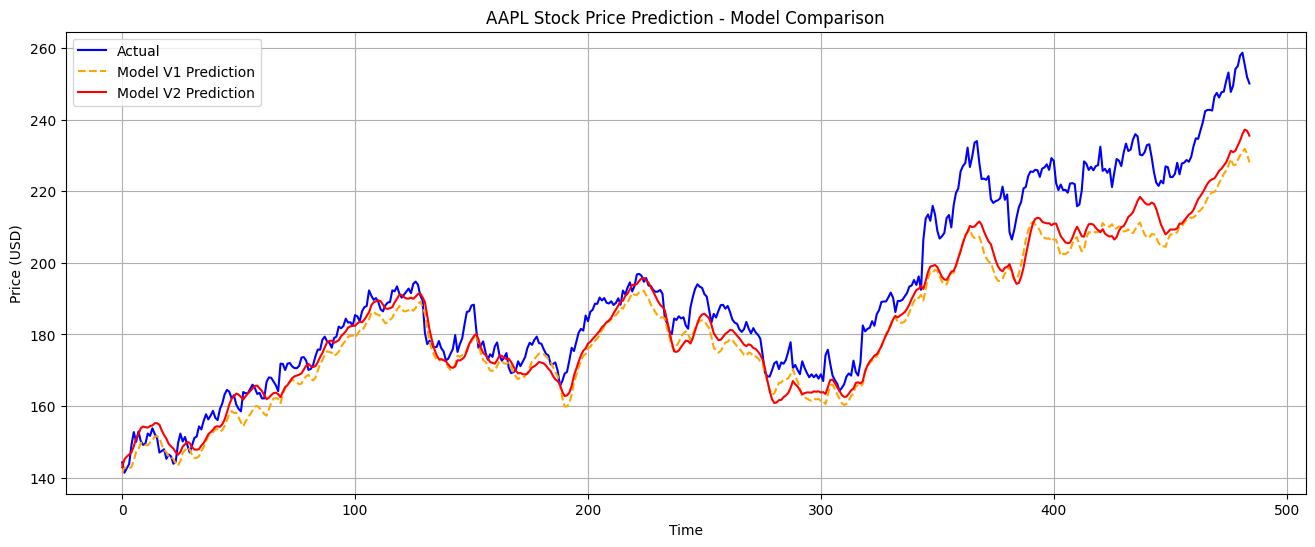

In [25]:
plt.figure(figsize=(16, 6))
plt.plot(actual, label='Actual', color='blue')
plt.plot(pred_v1, label='Model V1 Prediction', linestyle='--', color='orange')
plt.plot(pred_v2, label='Model V2 Prediction', linestyle='-', color='red')
plt.title('AAPL Stock Price Prediction - Model Comparison')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
# prompt: send code to zip this data folder and download it
# /content/data

!zip -r /content/data.zip /content/data
from google.colab import files
files.download("/content/data.zip")


  adding: content/data/ (stored 0%)
  adding: content/data/best_model.h5 (deflated 7%)
  adding: content/data/final_model_v2.keras (deflated 8%)
  adding: content/data/model_v1.keras (deflated 11%)
  adding: content/data/final_model.keras (deflated 8%)
  adding: content/data/best_model_v2.h5 (deflated 8%)
  adding: content/data/processed_stock.csv (deflated 54%)
  adding: content/data/raw_stock1.csv (deflated 56%)
  adding: content/data/model_v2.keras (deflated 8%)
  adding: content/data/.ipynb_checkpoints/ (stored 0%)
  adding: content/data/scaler_multi.save (deflated 27%)
  adding: content/data/scaler.pkl (deflated 17%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
import os
import zipfile
from google.colab import files  # Only needed if running in Google Colab

# Assuming model_v1 and model_v2 are your trained Keras model objects

# Define the folder to save the models
models_folder = "saved_models"
os.makedirs(models_folder, exist_ok=True)

# Save the first model (V1)
model_v1_path = os.path.join(models_folder, "model_v1.keras")
model_v1.save(model_v1_path)
print(f"model_v1 saved to: {model_v1_path}")

# Save the second model (V2)
model_v2_path = os.path.join(models_folder, "model_v2.keras")
model_v2.save(model_v2_path)
print(f"model_v2 saved to: {model_v2_path}")

# Create a zip file
zip_file_path = "trained_models.zip"
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for root, _, files_in_folder in os.walk(models_folder):
        for file in files_in_folder:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, models_folder))

print(f"\nModels zipped to: {zip_file_path}")

# Download the zip file (only works in Google Colab)
try:
    files.download(zip_file_path)
except ImportError:
    print("\nDownloading the zip file is only supported in Google Colab.")
    print(f"Please find the '{zip_file_path}' file in your Colab file browser.")

model_v1 saved to: saved_models/model_v1.keras
model_v2 saved to: saved_models/model_v2.keras

Models zipped to: trained_models.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
import os
import zipfile
import pickle
import h5py
from google.colab import files  # Only needed if running in Google Colab
import numpy as np # Assuming your scaler might involve numpy arrays

# Assuming model_v1, model_v2, and your scaler object are in variables

# Define the folder to save the models and scaler
save_folder = "saved_artifacts"
os.makedirs(save_folder, exist_ok=True)

# Save the first model (V1) as .keras
model_v1_keras_path = os.path.join(save_folder, "model_v1.keras")
model_v1.save(model_v1_keras_path)
print(f"model_v1 saved as .keras to: {model_v1_keras_path}")

# Save the first model (V1) as .h5
model_v1_h5_path = os.path.join(save_folder, "model_v1.h5")
model_v1.save(model_v1_h5_path)
print(f"model_v1 saved as .h5 to: {model_v1_h5_path}")

# Save the second model (V2) as .keras
model_v2_keras_path = os.path.join(save_folder, "model_v2.keras")
model_v2.save(model_v2_keras_path)
print(f"model_v2 saved as .keras to: {model_v2_keras_path}")

# Save the second model (V2) as .h5
model_v2_h5_path = os.path.join(save_folder, "model_v2.h5")
model_v2.save(model_v2_h5_path)
print(f"model_v2 saved as .h5 to: {model_v2_h5_path}")

# Save the scaler object (assuming it's a standard scaler from scikit-learn or similar)
scaler_path = os.path.join(save_folder, "scaler.pkl")
with open(scaler_path, 'wb') as file:
    pickle.dump(scaler, file)
print(f"Scaler saved to: {scaler_path}")

# Create a zip file
zip_file_path = "trained_artifacts.zip"
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for root, _, files_in_folder in os.walk(save_folder):
        for file in files_in_folder:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, save_folder))

print(f"\nArtifacts zipped to: {zip_file_path}")

# Download the zip file (only works in Google Colab)
try:
    files.download(zip_file_path)
except ImportError:
    print("\nDownloading the zip file is only supported in Google Colab.")
    print(f"Please find the '{zip_file_path}' file in your Colab file browser.")

model_v1 saved as .keras to: saved_artifacts/model_v1.keras
model_v1 saved as .h5 to: saved_artifacts/model_v1.h5
model_v2 saved as .keras to: saved_artifacts/model_v2.keras
model_v2 saved as .h5 to: saved_artifacts/model_v2.h5
Scaler saved to: saved_artifacts/scaler.pkl

Artifacts zipped to: trained_artifacts.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>